In [75]:
# Script designed to sort through the data file and assign dominant grass types etc.

import netCDF4 as nc4
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

In [12]:
# Imports files from previous files needed

%store -r hansen_ds_2000
%store -r hansen_ds

%store -r sim_2000
%store -r plant_13
%store -r plant_14

'''
%store -r plant_1
%store -r plant_2
%store -r plant_3
%store -r plant_4
%store -r plant_5
%store -r plant_6
%store -r plant_7
%store -r plant_8
'''

In [14]:
# Saves the measured tree loss data (hansen data) as nc file
hansen_ds.to_netcdf("hansen_ds.nc")

# Saves a single year of hansen data as nc file
hansen_ds_2000.to_netcdf("hansen_ds_2000.nc")

# Saves the climate model input file data as nc file
sim_2000.to_netcdf("sim_2000.nc")


# Saves all the grasses as nc files, files indicate the climate model input data, where the grass type is over 10%
plant_13.to_netcdf("plant_13.nc")
plant_14.to_netcdf("plant_14.nc")

'''
# Saves all the trees as nc files, files indicate climate model input data, where tree type is over 10%
plant_1.to_netcdf("plant_1.nc")
plant_2.to_netcdf("plant_2.nc")
plant_3.to_netcdf("plant_3.nc")
plant_4.to_netcdf("plant_4.nc")
plant_5.to_netcdf("plant_5.nc")
plant_6.to_netcdf("plant_6.nc")
plant_7.to_netcdf("plant_7.nc")
plant_8.to_netcdf("plant_8.nc")
'''

In [21]:
# Show that all files are the correct shape (192, 288) and line up 
print(hansen_ds.shape) 
# (lat, lon, year)

print(hansen_ds_2000.shape) 
# (lat, lon)

print(sim_2000.shape) 
# (plant type, lat, lon)

print(plant_14.shape) 
# (lat, lon)

(192, 288, 16)
(192, 288)
(15, 192, 288)
(192, 288)


In [23]:
# Creates file of dominant grass type across map, used to identify what grass type to turn trees into

# Creates new variable to work with with the shape (192, 288)
sim_2000_dom_grass = sim_2000[0,:,:]

# Loop through lat and lon
for i in np.arange(0,192):
    for j in np.arange(0,288):
        
        # If both grasses equal zero
        if plant_13[i,j] == 0 and plant_14[i,j] == 0:
            
            # Check if the lat is less than 40 and more than -40 (between 40 and -40)
            if sim_2000_dom_grass[i,j]['lsmlat'] <= 40 and sim_2000_dom_grass[i,j]['lsmlat'] >= -40:
                sim_2000_dom_grass[i,j] = 14 # Set dominant grass to 14
            else:
                sim_2000_dom_grass[i,j] = 13 # If not between 40 and -40, set to 13
                
        # Sets the dominant grasses, without having to worry about both equaling 0
        elif plant_13[i,j] > plant_14[i,j]:
            sim_2000_dom_grass[i,j] = 13
        else:
            sim_2000_dom_grass[i,j] = 14
            

sim_2000_dom_grass.to_netcdf("mean_dom_grass.nc")

#Notes:
#Uses similation input data averaged over all years
#Defalt to 13 everywhere else
#Default to 14 (40 to -40)

In [57]:
# SKIP HERE TO LOAD FILES WHEN NOT RUNNING ABOVE BOXES

hansen_ds = xr.open_dataarray("hansen_ds.nc")
mean_dom_grass = xr.open_dataarray("mean_dom_grass.nc")
sim_2000 = xr.open_dataarray("sim_2000.nc")


'''
# Show types stay the same
print(type(sim_2000_dom_grass))
print(type(mean_dom_grass))
'''

'\n# Show types stay the same\nprint(type(sim_2000_dom_grass))\nprint(type(mean_dom_grass))\n'

In [58]:
# Convert NAN to 0 in Hansen Dataset
hansen_ds= np.nan_to_num(hansen_ds)

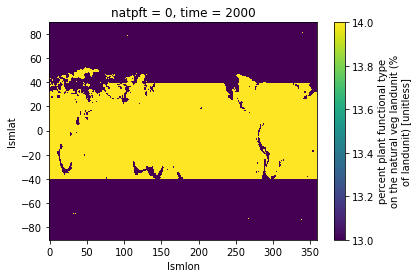

In [59]:
# Plot dominant grass
mean_dom_grass.plot()

In [60]:
# Create one year of sim_2000 to modify
# Coords: [Plant types, lat, lon]
sim_2000_test = sim_2000[:,:,:]
sim_2000_test.shape

(15, 192, 288)

In [68]:
# Mini loop, (150-155, 200-205)

#loop through lat -- i
for i in np.arange(150,155):
    #loop through lon -- j
    for j in np.arange(200,205): 
        # Selects specfic year of forest loss
        forest_loss = hansen_ds[i,j,0]
        # Count total tree loss in a single box
        tree_loss_total = 0 
        
        #loop though plants numbers -- k
        for k in [1,2,3,4,5,6,7,8]: 
            tree_value = sim_2000[k,i,j] # Gets old tree value from similation input data
            new_tree_value = tree_value * (1-forest_loss) # Creates new tree value that accounts for fraction of tree loss
            loss = tree_value - new_tree_value # Calculates tree loss amount for tree type in the box
            tree_loss_total = tree_loss_total + loss # Aggreagates loss across PFTs (trees)
            sim_2000_test[k,i,j] = new_tree_value # Assigns new tree value in the manipulated file
            
        grass_type = mean_dom_grass[i,j].values
        #print(grass_type)
        tree_loss_total = tree_loss_total.values
        #print(tree_loss_total)
        current_grass = sim_2000[int(grass_type),i,j]
        sim_2000_test[int(grass_type),i,j] = current_grass + tree_loss_total     
            
            
            
# Reduce each forest value by the amount of forest loss, multiply by (1-forest loss)
# Calculate removed forest, replace with dominant grass type in cell

In [69]:
print(sim_2000_test[1,150,200].values)
print(sim_2000[1,150,200].values)
print(sim_2000_test[13,150,200].values)
print(sim_2000[13,150,200].values)

print(sim_2000_test[1,150,200].values+sim_2000_test[13,150,200].values+sim_2000_test[7,150,200].values)
print(sim_2000[1,150,200].values+sim_2000[13,150,200].values+sim_2000[7,150,200].values)


#test that all PFTs sum to 100 still
# make some plots to see if trees go up and grass goes down

0.6926783184434562
0.6926815236979302
98.02642653212716
98.0264183959282
99.78471706966218
99.78471706966218


In [70]:
print(sim_2000_test[:,150,202].sum()) #All sum to 100



<xarray.DataArray 'PCT_NAT_PFT' ()>
array(100.)
Coordinates:
    time     int32 ...
    lsmlat   float64 50.62
    lsmlon   float64 252.5


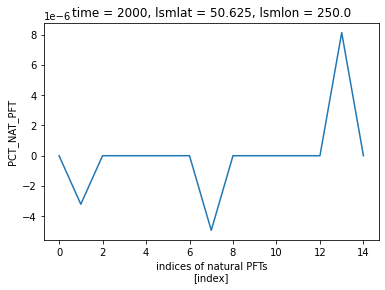

In [71]:
(sim_2000_test[:,150,200]- sim_2000[:,150,200]).plot()

# Trees decrease, grasses increase 


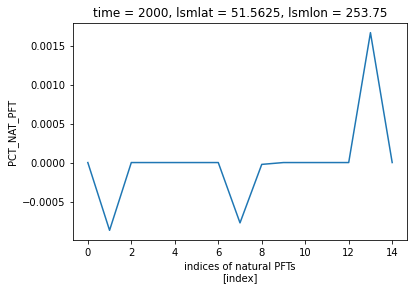

In [72]:
(sim_2000_test[:,151,203]- sim_2000[:,151,203]).plot()


In [73]:
# Run with whole map

#loop through lat -- i
for i in np.arange(0,192):
    #loop through lon -- j
    for j in np.arange(0,288): 
        # Selects specfic year of forest loss
        forest_loss = hansen_ds[i,j,0]
        # Count total tree loss in a single box
        tree_loss_total = 0 
        
        #loop though plants numbers -- k
        for k in [1,2,3,4,5,6,7,8]: 
            tree_value = sim_2000[k,i,j] # Gets old tree value from similation input data
            new_tree_value = tree_value * (1-forest_loss) # Creates new tree value that accounts for fraction of tree loss
            loss = tree_value - new_tree_value # Calculates tree loss amount for tree type in the box
            tree_loss_total = tree_loss_total + loss # Aggreagates loss across PFTs (trees)
            sim_2000_test[k,i,j] = new_tree_value # Assigns new tree value in the manipulated file
            
        grass_type = mean_dom_grass[i,j].values
        #print(grass_type)
        tree_loss_total = tree_loss_total.values
        #print(tree_loss_total)
        current_grass = sim_2000[int(grass_type),i,j]
        sim_2000_test[int(grass_type),i,j] = current_grass + tree_loss_total     
            

In [74]:
%store sim_2000_test
sim_2000_test.to_netcdf("sim_2000_test.nc")


Stored 'sim_2000_test' (DataArray)


In [2]:
%store -r sim_2000_test

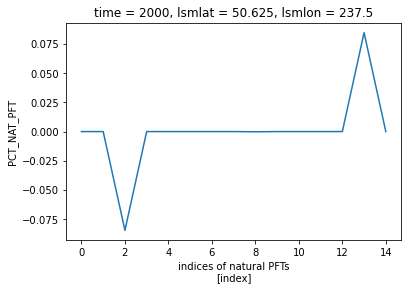

In [143]:
(sim_2000_test[:,150,190] - sim_2000[:,150,190]).plot()

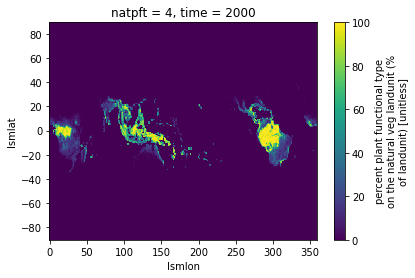

In [4]:
sim_2000_test[4,:,:].plot()

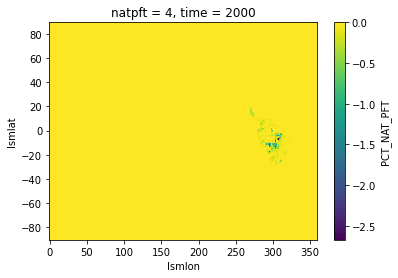

In [7]:
(sim_2000_test[4,:,:]-sim_2000[4,:,:]).plot()

In [ ]:
(sim_2000_test[14,:,:]-sim_2000[14,:,:]).plot()

In [ ]:
# NOT WORKING 
# Attempt to add year 2001

sim_2001_test = sim_2000_test

for i in np.arange(0,192): #loop through lat -- i
    for j in np.arange(0,288): #loop through lon -- j
        forest_loss = hansen_ds[i,j,1] # 99% sure is fraction check on whether I need a factor of 100, check fraction or percent, convert to fraction
        tree_loss_total = 0
        for k in [1,2,3,4,5,6,7,8]: #loop though plants numbers -- k
            tree_value = sim_2000_test[k,i,j]
            new_tree_value = tree_value * (1-forest_loss) #forest loss should be in fraction
            loss = tree_value - new_tree_value
            tree_loss_total = tree_loss_total + loss #this aggreagates loss across PFTs (trees)
            #print(tree_loss_total)
            sim_2001_test[k,i,j] = new_tree_value
        grass_type = sim_2000_dom_grass[i,j].values
        #print(grass_type)
        tree_loss_total = tree_loss_total.values
        #print(tree_loss_total)
        current_grass = sim_2000_test[int(grass_type),i,j]
        sim_2001_test[int(grass_type),i,j] = current_grass + tree_loss_total   

In [ ]:
# for adding years into the equation
# Build on the first year 


# save to netcdf files
# make a function (new files) to pass in the files and save netcdfs 
# 

# special amazon case -- amazon does not change, and NA doesn't change 
# 

In [20]:
'''
# Need to finish the tree type
sim_2000_dom_tree = sim_2000[0,:,:]

for i in np.arange(0,192):
    for j in np.arange(0,288):
        if plant_13[i,j] >= plant_14[i,j]:
            sim_2000_dom_grass[i,j] = 13
        else:
            sim_2000_dom_grass[i,j] = 14
'''

'\n# Need to finish the tree type\nsim_2000_dom_tree = sim_2000[0,:,:]\n\nfor i in np.arange(0,192):\n    for j in np.arange(0,288):\n        if plant_13[i,j] >= plant_14[i,j]:\n            sim_2000_dom_grass[i,j] = 13\n        else:\n            sim_2000_dom_grass[i,j] = 14\n'

/home/disk/p/rlys/anaconda3/envs/pangeo_copy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1665: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


/home/disk/p/rlys/anaconda3/envs/pangeo_copy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


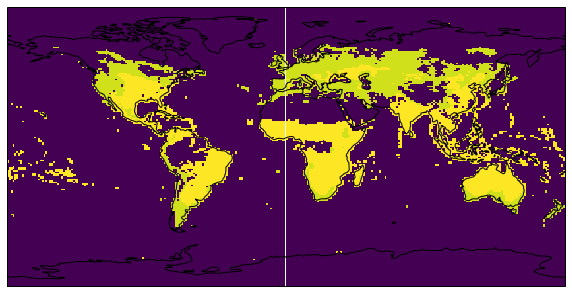

In [19]:
# Plot of dominant grass type
projection = ccrs.PlateCarree()
fig= plt.figure(figsize=(10,7))
ax1 = plt.axes(projection=projection)
ax1.set_global()
ax1.coastlines()
plt.pcolor(sim_2000['lsmlon'], sim_2000['lsmlat'], sim_2000_dom_grass, transform=ccrs.PlateCarree())


In [ ]:
# smaller range 
# even just one grid cell
# good to start with just 4

new_2000 = sim_2000
for i in np.arange(0,192): 
    for j in np.arange(0,288): 
        obs = hansen_ds_2000[i,j]
        if obs > 0:
            new_2000[4,i,j] = new_2000[4,i,j] - obs #double check same form, change to tree %
            
    
        if sim_2000_dom_grass[i,j] == 13:
            new_2000[13,i,j] = hansen_ds_2000[i,j] + obs
        else: 
            new_2000[14,i,j] = hansen_ds_2000[i,j] + obs

            
#eventually make percentages of each tree
# work on thing to do if there is not enough tree to subtract

In [9]:
new_2000 = sim_2000

new_2000.shape

(15, 192, 288)